[](http://https://bernardmarr.com/img/How%20Tesla%20Is%20Using%20Artificial%20Intelligence%20to%20Create%20The%20Autonomous%20Cars%20Of%20The%20Future.jpg)

In [1]:
import numpy as np
import PIL 
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
from glob import glob
import random
import cv2
import warnings
warnings.simplefilter('ignore')

In [2]:
!pip install ultralytics 

  Using cached opencv_python-4.8.1.78-cp37-abi3-macosx_11_0_arm64.whl (33.1 MB)


In [3]:
import ultralytics
from ultralytics import YOLO
yolo_model = YOLO('yolov8m.pt')

['data/frame0.jpeg', 'data/frame1.jpeg', 'data/frame2.jpeg', 'data/frame3.jpeg']


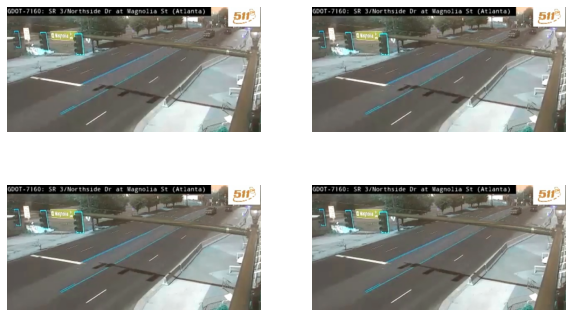

In [4]:
root_path = 'data/*'
num_samples = 4
images_data = glob(root_path)
images_data.sort(key = lambda x: int(x.split(".")[0].split("e")[1]))
random_image = images_data[:num_samples]
print(random_image)
plt.figure(figsize=(10,6))
for i in range(num_samples):
    plt.subplot(2,2,i+1)
    plt.imshow(cv2.imread(random_image[i]))
    plt.axis('off')


In [5]:
# Create a list to store the images
images = []
counter = 0
for i in range(num_samples):
    yolo_outputs = yolo_model.predict(random_image[i], conf = 0.5, classes=[2, 5, 7, 3, 6])
    output = yolo_outputs[0]
    box = output.boxes
    names = output.names
    
    for j in range(len(box)):
        labels = names[box.cls[j].item()]
        coordinates = box.xyxy[j].tolist()
        confidence = np.round(box.conf[j].item(), 2)
        #print(f'In this image {len(box)} objects has been detected.')
        print(f'Object {j + 1} is: {labels}')
        print(f'Coordinates are: {coordinates}')
        print(f'Confidence is: {confidence}')
        print('-------')
        
    # Store the image in the 'images' list
    images.append(output.plot()[:, :, ::-1])
    counter += len(box)
print(counter)


image 1/1 /Users/sanshubhkukutla/Documents/projects/RoadBrain/data/frame0.jpeg: 320x640 (no detections), 172.1ms
Speed: 1.6ms preprocess, 172.1ms inference, 7.6ms postprocess per image at shape (1, 3, 320, 640)

image 1/1 /Users/sanshubhkukutla/Documents/projects/RoadBrain/data/frame1.jpeg: 320x640 (no detections), 148.9ms
Speed: 0.8ms preprocess, 148.9ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 640)

image 1/1 /Users/sanshubhkukutla/Documents/projects/RoadBrain/data/frame2.jpeg: 320x640 2 cars, 145.0ms
Speed: 0.8ms preprocess, 145.0ms inference, 4.2ms postprocess per image at shape (1, 3, 320, 640)
Object 1 is: car
Coordinates are: [524.5452880859375, 50.86773681640625, 544.5347900390625, 66.68173217773438]
Confidence is: 0.53
-------
Object 2 is: car
Coordinates are: [477.1233215332031, 53.77375793457031, 505.2397766113281, 74.67377471923828]
Confidence is: 0.51
-------

image 1/1 /Users/sanshubhkukutla/Documents/projects/RoadBrain/data/frame3.jpeg: 320x640 2 cars



-------------------------------------- Images after object detection with YOLOV8 --------------------------------


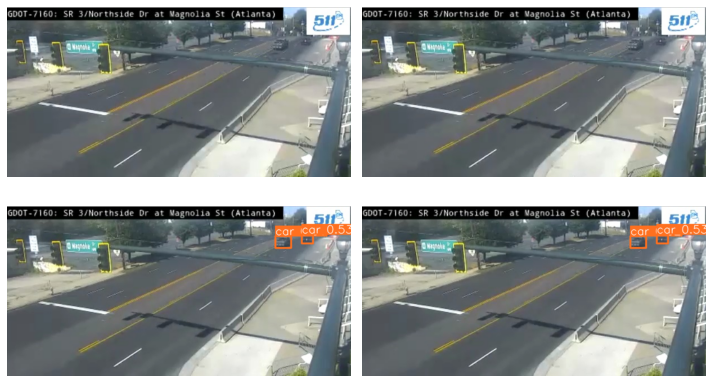

In [6]:
# plotting the images after object detection
print('\n\n-------------------------------------- Images after object detection with YOLOV8 --------------------------------')    

plt.figure(figsize=(10,6))
for i, img in enumerate(images):
    plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    plt.axis('off')    
plt.tight_layout()
plt.show()


In [7]:
#Load the custom object detector
# Replace with your detector
from collections import defaultdict
from collections import deque
#Initialize an empty list to store active trackers
trackers = []
buffers = defaultdict(int)
#Initialize the video capture
cap = cv2.VideoCapture('vidData/video1.mp4')  # Replace with your video file
maxVal = 0
#Read the first frame
ret, frame = cap.read()

#Exit if the video file is not opened successfully
if not ret:
    print("Error: Unable to open the video file.")
    exit()

#Process each frame

while True:
    # Read a new frame
    ret, frame = cap.read()

    if not ret:
        break

    # Convert the frame to grayscale for the custom object detector
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect objects using the custom object detector
    yolo_outputs = yolo_model.predict(frame, conf = 0.5, classes=[2, 5, 7, 3, 6])
    output = yolo_outputs[0]
    box = output.boxes
    tracker_cords = deque()
    
    # Update existing trackers
    for tracker in trackers:
        success, bbox = tracker.update(frame)

        if success:
            (x, y, w, h) = [int(i) for i in bbox]
            tracker_cords.append((x, y, w, h))
            if len(tracker_cords) > len(trackers):
                tracker_cords.popleft()
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
        else:
            (x, y, w, h) = [int(i) for i in bbox]
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
            buffers[tracker] += 1
            if buffers[tracker] > 2000:
                trackers.remove(tracker)
                del buffers[tracker]
    maxVal = max(maxVal,len(trackers))
    # Initialize trackers for new objects
    for target in box.xyxy:
        target = target.tolist()
        (x, y, w, h) = int(target[0]), int(target[1]), int(target[2]) - int(target[0]), int(target[3]) - int(target[1])
        if all(cv2.norm((x, y, w, h), (tx[0], tx[1], tx[2] - tx[0], tx[3] - tx[1])) > 700 for tx in tracker_cords):
            new_tracker = cv2.TrackerKCF_create()
            new_tracker.init(frame, (x, y, w, h))
            trackers.append(new_tracker)

    # Display the frame
    cv2.imshow("Object Tracking", frame)

    # Exit on 'q' key press
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

#Release the video capture object
cap.release()

#Close all windows
cv2.destroyAllWindows()
print(maxVal)


0: 320x640 1 car, 147.6ms
Speed: 1.0ms preprocess, 147.6ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 1 car, 152.9ms
Speed: 1.0ms preprocess, 152.9ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 1 car, 149.3ms
Speed: 0.9ms preprocess, 149.3ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 2 cars, 149.9ms
Speed: 1.1ms preprocess, 149.9ms inference, 0.5ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 1 car, 152.3ms
Speed: 0.9ms preprocess, 152.3ms inference, 0.6ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 1 car, 152.1ms
Speed: 1.0ms preprocess, 152.1ms inference, 0.5ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 1 car, 156.1ms
Speed: 0.9ms preprocess, 156.1ms inference, 0.5ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 1 car, 148.4ms
Speed: 0.9ms preprocess, 148.4ms inference, 0.6ms postprocess per image at shape (1, 3, 320, 640)


0: 320x640 (no detections), 151.1ms
Speed: 1.0ms preprocess, 151.1ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 (no detections), 147.5ms
Speed: 0.9ms preprocess, 147.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 (no detections), 148.7ms
Speed: 0.9ms preprocess, 148.7ms inference, 0.5ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 (no detections), 147.4ms
Speed: 0.8ms preprocess, 147.4ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 (no detections), 150.1ms
Speed: 0.9ms preprocess, 150.1ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 (no detections), 150.0ms
Speed: 0.9ms preprocess, 150.0ms inference, 0.3ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 (no detections), 147.7ms
Speed: 0.8ms preprocess, 147.7ms inference, 0.3ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 (no detections), 151.5ms
Speed: 0.8ms prepr

Speed: 0.9ms preprocess, 158.4ms inference, 0.6ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 1 car, 154.8ms
Speed: 0.8ms preprocess, 154.8ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 1 car, 159.0ms
Speed: 1.5ms preprocess, 159.0ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 1 car, 150.9ms
Speed: 0.8ms preprocess, 150.9ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 1 car, 148.1ms
Speed: 1.1ms preprocess, 148.1ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 1 car, 148.3ms
Speed: 0.8ms preprocess, 148.3ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 1 car, 155.4ms
Speed: 0.9ms preprocess, 155.4ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 1 car, 150.7ms
Speed: 0.9ms preprocess, 150.7ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 1 car, 150.3ms



0: 320x640 1 car, 150.4ms
Speed: 0.9ms preprocess, 150.4ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 1 car, 149.6ms
Speed: 0.9ms preprocess, 149.6ms inference, 0.5ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 1 car, 144.3ms
Speed: 0.8ms preprocess, 144.3ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 1 car, 144.2ms
Speed: 0.9ms preprocess, 144.2ms inference, 0.5ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 1 car, 142.8ms
Speed: 0.9ms preprocess, 142.8ms inference, 0.5ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 1 car, 144.1ms
Speed: 0.9ms preprocess, 144.1ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 1 car, 144.1ms
Speed: 0.8ms preprocess, 144.1ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 1 car, 148.5ms
Speed: 0.8ms preprocess, 148.5ms inference, 0.6ms postprocess per image at shape (1, 3, 320, 640)



0: 320x640 (no detections), 146.2ms
Speed: 0.9ms preprocess, 146.2ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 (no detections), 146.3ms
Speed: 0.8ms preprocess, 146.3ms inference, 0.3ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 (no detections), 145.6ms
Speed: 0.9ms preprocess, 145.6ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 (no detections), 144.8ms
Speed: 0.8ms preprocess, 144.8ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 (no detections), 145.0ms
Speed: 0.8ms preprocess, 145.0ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 (no detections), 144.0ms
Speed: 0.8ms preprocess, 144.0ms inference, 0.3ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 (no detections), 148.5ms
Speed: 0.8ms preprocess, 148.5ms inference, 0.3ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 (no detections), 150.4ms
Speed: 0.9ms prepr